# Computing MSR from fortranic spiral tip location data
Tim Tyree<br>
6.25.2022

In [2]:
from IPython.display import clear_output
clear_output(wait=True)

In [3]:
import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

In [4]:
os.chdir(nb_dir)
from lib import *

In [5]:
import cupy, cudf
from lib.rapids_func import *

ModuleNotFoundError: No module named 'cupy'

In [ ]:
import seaborn as sns
import matplotlib.ticker as mtick

In [ ]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

# define module

In [8]:
# #for parsing fortranic data
# import re
# from itertools import zip_longest
# def strip_line_to_csv(line):
#     """
#     Example Usage:
# str_csv=strip_line_to_csv(line)
# value_tuple=eval(str_csv)
#     """
#     str_csv=re.sub(r'\s+', ',', line.strip())
#     return str_csv

# def grouper(iterable, n, fillvalue=None):
#     args = [iter(iterable)] * n
#     return zip_longest(*args, fillvalue=fillvalue)

# def parse_fortranic_tip_pos(input_dir):
#     """
#     Example Usage:
# input_dir='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001'
# df_log=parse_fortranic_tip_pos(input_dir)
# #partition df_log into a folder of tip logs
# log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
# # save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=True)
# save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
# print(f"saved to spiral tip positions to\n{log_folder_parquet=}")
# #determine width and height of the computational domain input the discretization
# width,height=df_log.describe().loc['max'][['x','y']].values.T
# DT=g['t'].min()
# printing=True
# if printing:
#     print(df_log.describe().loc[['min','max']][['x','y']])
#     print(f"{width=}, {height=}, {DT=}")
#     """
#     #read in fortranic spiral tip locations
#     trial_num=0
#     dict_pos_lst=[]
#     with open(input_dir) as f:
#         for lines in grouper(f, 3, ''):
#             assert len(lines) == 3
#             #process lines
#             str_csv=strip_line_to_csv(lines[0])
#             value_tuple=eval(str_csv)
#             t=value_tuple[0]
#             n=value_tuple[1]
#             row3=value_tuple[2]
#             if n>0:
#                 str_csv=strip_line_to_csv(lines[1])
#                 x_tuple=eval(str_csv)
#                 str_csv=strip_line_to_csv(lines[2])
#                 y_tuple=eval(str_csv)
#                 #record for each position
#                 for x,y in zip(x_tuple,y_tuple):
#                     dict_pos=dict(trial_num=trial_num,t=t,n=n,x=x-1,y=y-1) #-1 makes wj's min position 0 and max ~ width, as i have been using
#                     dict_pos_lst.append(dict_pos)
#             else:
#                 trial_num+=1
#     df_log=pd.DataFrame(dict_pos_lst)
#     return df_log

# define model ported to lib

In [1]:
# #TODO: move to lib.utils.parquetio.py
# import shutil, os, pandas
# def save_df_to_parquet_by(df,folder_parquet,by='trial_num',
#                           compression='snappy',index=None,
#                           **kwargs):
#     """save_df_to_parquet_by groups pd.DataFrame instance, df by by='trial_num', 
#     and then saves each group into a separate parquet file in 
    
#     options for compression: {'snappy', 'gzip', 'brotli', None}, default 'snappy'
#     see df.to_parquet? for details on compression
    
#     Example Usage:
# log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
# save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
#     """
#     #clear cache before saving into it
#     if os.path.exists(folder_parquet):
#         shutil.rmtree(folder_parquet,ignore_errors=True)
#     #save to parquet
#     df.to_parquet(folder_parquet,index=index,
#                      compression=compression,
#                       partition_cols=[by])
#     return True

# def load_parquet_by_trial_num(trial_num,folder_parquet,reset_index=True,**kwargs):
#     """
#     Example Usage:
# log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
# g=load_parquet_by_trial_num(trial_num=639,folder_parquet=log_folder_parquet)
#     """
#     log_dir_parquet=os.path.join(folder_parquet,f"{trial_num=}")
#     df=pd.read_parquet(log_dir_parquet)
#     df['trial_num']=trial_num
#     if reset_index:
#         df.reset_index(inplace=True)
#     #set index dtyp
#     #df.index = df.index.map(str)
#     #df.index = df.index.map(np.int64)
#     df.index = df.index.astype(np.int64)
#     return df

In [22]:
# def comp_moving_avg_pbc_trajectories_cu(traj,navg1,width,height,t_col='t',pid_col='particle',printing=True,**kwargs):
#     """comp_moving_avg_pbc_trajectories_cu returns a cudf.DataFrame instance that uses the gpu to smooth the trajectories using a moving average of window length, navg1, respecting pbc.
#     traj is a pandas.DataFrame or a cudf.DataFrame instance with fields 'x','y' containing location on a square grid with periodic boundary conditions (pbc).
#     t_col is the field containing time.
#     the particle is index by pid_col.
    
#     Example Usage:
# df=comp_moving_avg_pbc_trajectories_cu(traj,navg1,width,height)#,t_col='t',pid_col='particle',printing=True)#,**kwargs)
#     """
#     #GOAL: compute smoothed trajectories, as before
#     # t_col='t'
#     #     df=pd.read_csv(input_fn)
#     #     DT=np.around(get_DT(df, t_col=t_col, pid_col=pid_col),5);print(f"DT={DT}")
#     #     # ds=5 #cm
#     #     # DS=ds/width
#     # #     width=200
#     #     height=width
#     # use_drop_shorter_than=True
#     # # drop_shorter_than=50 #ms
#     # drop_shorter_than=10 #ms
#     #     tmin=100.#ms
#     #     pid_col='particle'
#     #DONE: see if the gpu-accelerated version works, as before. yes.
#     #df=cudf.read_csv(input_fn)
#     df=cudf.DataFrame(traj)
#     col_keep_lst=['x','y',pid_col,t_col]

#     #sort by particle and then by time
#     df=df.sort_values([pid_col, t_col], ascending=True).copy()
#     df=apply_unwrap_xy_trajectories_pbc(df,t_col=t_col,pid_col=pid_col,width=width,height=height)
#     df=apply_moving_avg_xy_trajectories(df,t_col=t_col,pid_col=pid_col,navg1=navg1,x_col='x_unwrap',y_col='y_unwrap')
#     # df=apply_unwrap_xy_trajectories_pbc_serial(df,t_col=t_col,pid_col=pid_col,width=width,height=height)
#     # df=apply_moving_avg_xy_trajectories_serial(df,t_col=t_col,pid_col=pid_col,navg1=navg1,x_col='x_unwrap',y_col='y_unwrap')
#     #compute rewrapped coordinates
#     df['x']=df['x_unwrap']-df['dx_unwrap']
#     df['y']=df['y_unwrap']-df['dy_unwrap']
#     #CONFIRMED: by increasing navg1, I can decrease the max displacement for all particles.
#     #DONE: add unique identifier for whole trial that is unique accross different csv files
#     #add unique identifier for each particle that is unique accross different csv files
#     # fn = os.path.basename(input_fn)
#     # event_id_int=float('1'+(''.join(re.findall(r'-?\d+\d*',fn))))
# #     df['event_id_int']= int(trial_num) #int(event_id_int)
#     # col_keep_lst=['x','y',t_col,pid_col,'event_id_int',"dx_unwrap","dy_unwrap"]
#     # df=df[col_keep_lst].copy()
#     return df

In [23]:
# type(og_stdout)

In [24]:
# og_stdout.

In [25]:
# def copy_df_as_pandas(df):
#     """copy_df_as_pandas takes pandas.DataFrame and cudf.DataFrame instances alike and returns a copy of the df as a pandas.DataFrame (perhaps useful good for saving)."""
#     if str(type(df))=="<class 'cudf.core.dataframe.DataFrame'>":
#             df_=df.to_pandas()
#     else: #if str(type(dfr))=="<class 'pandas.core.frame.DataFrame'>":
#         df_=df.copy()
#     return df_

In [26]:
# #used in analysis for tshift_tare_routine and for trajectories
# # import os, sys
# class HiddenPrints:
#     """
#     Example Usage:
# og_stdout=sys.stdout
# with HiddenPrints(): #  (og_stdout=og_stdout):  #kwargs are not for with statements in py39...
#     traj = compute_track_tips_pbc(df_log_local, mem=mem, sr=sr, width=width, height=height)
    
#     Example Usage:
#  with HiddenPrints():
#     retval=tshift_tare_routine(df_R,navg2,max_num_groups=9e9,plotting=False,npartitions=10,R_col='R_nosavgol',printing=True)
#     """
#     def __enter__(self):
#         self._original_stdout = sys.stdout
#         sys.stdout = open(os.devnull, 'w')

#     def __exit__(self, exc_type, exc_val, exc_tb):
#         sys.stdout.close()
#         sys.stdout = self._original_stdout

In [16]:
# def align_timeseries_simple(dfr,df_pairs,
#                             P_col='index_pairs',
#                             R_col='R_nosavgol',
#                             T_col='tdeath',
#                             T_col_out='talign',
#                             max_num_obs_align=3,
#                             **kwargs):
#     """align_timeseries_simple shifts the times by tshift, determined by linear estimation of the true extremal time.
    
#     Example: Usage:
# df_R,df_P=align_timeseries_simple(dfr,df_pairs,
#                             P_col='index_pairs',
#                             R_col='R_nosavgol',
#                             T_col='tdeath',
#                             T_col_out='talign',
#                             max_num_obs_align=3)
#     """
#     if str(type(dfr))=="<class 'cudf.core.dataframe.DataFrame'>":
#         df_R=dfr.to_pandas()
#     else: #if str(type(dfr))=="<class 'pandas.core.frame.DataFrame'>":
#         df_R=dfr.copy()
#     if str(type(dfr))=="<class 'cudf.core.dataframe.DataFrame'>":
#         df_P=df_pairs.to_pandas()
#     else: #if str(type(dfr))=="<class 'pandas.core.frame.DataFrame'>":
#         df_P=df_pairs.copy()

#     #initialize virtual memory
#     df_R[T_col_out]=0.
#     for index_pairs,row in df_P.iterrows():
#         df=df_R[df_R[P_col]==index_pairs]
#         d=df.sort_values(by=T_col).head(max_num_obs_align)
#         x_values=d[R_col].values
#         y_values=d[T_col].values

#         #compute slope from x_values,y_values
#         #get the y-intercept as -tshift
#         if x_values.shape[0] > 2:
#             # tshift=-y_intercept_of_ols
#             tshift=-comp_ols_simple(x_values,y_values)['b']
#         else:
#             if (x_values.shape[0] < 2):
#                 #tshift= NaN
#                 tshift=np.nan
#             elif (x_values[1]>x_values[0]): 
#                 # tshift=-y_intercept_of_linear_solution
#                 b=y_values[0]-x_values[0]*(y_values[1]-y_values[0])/(x_values[1]-x_values[0])
#                 tshift=-b
#             else:
#                 #annihilating positions only move towards each other 
#                 #tshift= NaN
#                 tshift=np.nan
#         #record tshift
#         df_R.loc[df_R['index_pairs']==index_pairs,'talign']=tshift
#     #compute tdeath_align
#     df_R['tdeath_align'] = df_R['tdeath'] + df_R['talign']
#     # df_R['talign'].plot.hist(bins=300)
#     return df_R,df_P

In [17]:
# def comp_lifetimes_by(df,t_col='t',by='particle',pid_lst=None,printing=False,**kwargs):
#     """
#     Example Usage:
# df_lifetimes_dfr=comp_lifetimes_by(df=dfr.to_pandas(),t_col='t',by='pid_other',pid_lst=None,printing=True)#,**kwargs)
#     """
#     dft=df.reset_index().groupby([by]).describe()[t_col]
#     df_lifetimes=-dft[['max','min']].T.diff().loc['min']
#     #DONE: print the lifetime of all pid_lst_stumps
#     if printing:
#         if pid_lst is None:
#             pid_lst=list(np.unique(df[by].values))
#         for i,pid in enumerate(pid_lst):
#             try:
#                 print(f"apparent lifetime of particle #{pid}:\t{df_lifetimes.loc[pid]} ms.")
#             except Exception as e:
#                 print(f"Warning: {e}")
#     return df_lifetimes

In [18]:
#DONE: moved to lib
# def FlowerPlot(df_traj,pid_lst,
#                 ax=None,
#                 x_col='x',
#                 y_col='y',
#                 c_col="t",
#                 pid_col='particle',
#                 width=200,
#                 height=200,
#                 fontsize=24,
#                 DS = 0.025,
#                 alpha=1,
#                 cmap="Blues",
#                 use_formatting=True,
#                 **kwargs):
#     """pid_lst is a list of particle indices.
#     Example Usage:
# ax=FlowerPlot(df_traj,pid_lst)#,x_col='x',y_col='y',c_col="t",pid_col='particle',width=200,height=200,fontsize=24,DS = 0.025,alpha=1,cmap="Blues",use_formatting=True)
#     """
#     if ax is None:
#         ax=plt.gca()
#     for pid in  pid_lst:
#         x_values ,y_values, c_values = df_traj[(df_traj[pid_col]==pid)][[x_col,y_col, c_col]].values.T.copy()
#         #scale to real coords
#         x_values *= DS
#         y_values *= DS
#         ax.scatter(x_values,y_values, s=20,
#                     c=c_values, vmin = np.min(c_values), vmax = np.max(c_values), cmap=cmap,alpha=alpha)#, **kwargs)
#         ax.scatter([x_values[0]],[y_values[0]], s=600,color='green',marker='*',alpha=0.7)
#         ax.scatter([x_values[-1]],[y_values[-1]], s=600,color='red',marker='*',alpha=0.7)

#     if use_formatting:
#         # format_plot
#         ax.set_xlabel('x (cm)', fontsize=fontsize)
#         ax.set_ylabel('y (cm)', fontsize=fontsize)
#         # We change the fontsize of minor ticks label
#         ax.tick_params(axis='both', which='major', labelsize=fontsize)
#         ax.tick_params(axis='both', which='minor', labelsize=0)
#         ax.grid('on')
#         ax.set_aspect('equal')
#     return ax


# define main routine

In [27]:
trial_num=300
log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
g.head()

[autoreload of lib.rapids_func.routines failed: Traceback (most recent call last):
  File "/home/timothytyree/miniconda3/envs/pyenv_ub/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/timothytyree/miniconda3/envs/pyenv_ub/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/timothytyree/miniconda3/envs/pyenv_ub/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/timothytyree/Documents/GitHub/care/notebooks/lib/rapids_func/routines/__init__.py", line 7, in <module>
    from .annihilation_analysis_cu import *
  File "/home/timothytyree/Documents/GitHub/care/no

NameError: name 'trial_num' is not defined

In [19]:
# def routine_annihilation_analysis_pbc(trial_num,
#     log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/',
#     DS=0.025, #cm/pixel
#     DT=1., #ms/frame
#     width=200.,  #pixels
#     height=200., #pixels
#     tavg1=0.,  #moving average window, in ms
#     tavg2=14., #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
#     min_termination_time=100.,
#     min_duration_thresh=1., #ms #minimum lifetime for a spiral tip position to be considered
#     max_Rfinal_thresh=0.5,  #cm
#     max_dtmax_thresh= 0.,   #cm # max disagreement between tmax for _self relative to _other
#     round_t_to_n_digits=7,
#     t_col='t',
#     pid_col='particle',
#     trial_col='trial_num',
#     use_tavg2=True, #unsmoothed R is preserved through R_nosavgol
#     testing=True,
#     printing=True,**kwargs):
#     """routine_annihilation_analysis_pbc loads spiral tip locations from cache,
#     computes the trajectories while enforcing periodic boundary conditions,
#     optionally smooths trajectories while enforcing periodic boundary conditions, on the gpu,
#     solves for annihilation events between pairs of particles subject to periodic boundary conditions, also on the gpu,
#     and computes a linear time adjustment so the time before annihilation, t', cooresponds to R=0 when t'=0.
#     routine_annihilation_analysis_pbc returns a dictionary containing dataframes at each of these steps, dict_msr.
#     the lifetimes of particles are included in dict_msr
    
#     Example Usage:
# dict_msr=routine_annihilation_analysis_pbc(trial_num=638,
#     log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/',
#     DS=0.025, #cm/pixel
#     DT=1., #ms/frame
#     width=200.,  #pixels
#     height=200., #pixels
#     tavg1=0.,  #moving average window, in ms
#     tavg2=14., #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
#     min_termination_time=100.,
#     min_duration_thresh=1., #ms #minimum lifetime for a spiral tip position to be considered
#     max_Rfinal_thresh=0.5,  #cm
#     max_dtmax_thresh= 0.,   #cm # max disagreement between tmax for _self relative to _other
#     round_t_to_n_digits=7,
#     t_col='t',
#     pid_col='particle',
#     trial_col='trial_num',
#     use_tavg2=True, #unsmoothed R is preserved through R_nosavgol
#     testing=True,
#     printing=True)
#     """
#     #load spiral tip positions from cache
#     g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
#     termination_time=g[t_col].max()
#     if termination_time<min_termination_time:
#         if printing:
#             print(f"Warning: {termination_time=} < {min_termination_time=}")
#         return None                                      
#     ###################################
#     # Track trajectories
#     ###################################
#     #compute spiral tip trajectories, as before
#     #DONE: find the mem, sr, that i used before
#     ds=DS*width #cm side length for the whole domain
#     sr=3*width #search range i(n pixels).  ignore for now.
#     mem=0  #memory for filling in missing data (in frames)
#     #DONE: generate tip tracks using pbc
#     with HiddenPrints(): 
#         traj = compute_track_tips_pbc(g, mem=mem, sr=sr, width=width, height=height)
#     if testing:
#         #test max times agree
#         assert g['t'].max()==traj['t'].max()
#     ##DONE(optional): save traj to cache
#     # traj_dir=os.path.abspath(input_fn)+'_log.csv'
#     # df_loc.to_csv(log_dir,index=False)
#     pid_lst = sorted(set(traj[pid_col].values))

#     printing_lifetimes_traj=True
#     if printing and printing_lifetimes_traj:
#         #compute the lifetimes
#         #print summary stats on particle lifetimes for one input folder
#         dft=traj.groupby(pid_col)[t_col].describe()
#         df_lifetimes=-dft[['max','min']].T.diff().loc['min']
#         print(f"termination time was {traj[t_col].max():.2f} ms")
#         print(f"printing summary stats on particle lifetimes:")
#         print(df_lifetimes.describe())
#         # print(df_lifetimes.head(10))
#         #print("\nPlease make a manual decision about minimum_lifetime, crop_start_by, and crop_end_by")

#     # #DONE: test that termination times still agree
#     # assert df_traj['t'].max()==traj['t'].max()
#     # # traj['t'].max()
#     # # df_traj['n'].max()
#     # #DONE: verified that these unwrapped trajectories exhibit no jumps greater than 20 pixels per ms
#     # jump_thresh=20
#     # # DONT: truncate trajectories to their first apparent jump (pbc jumps should have been removed already)
#     # df=df_traj.copy()# = pd.concat([unwrap_traj_and_center(traj[traj[pid_col]==pid].copy(), width, height, DS) for pid in pid_lst])
#     # #truncate trajectories to their first apparent jump (pbc jumps should have been removed already)
#     # df_lst = []
#     # for pid in  pid_lst:#[2:]:
#     #     d = df[(df.particle==pid)].copy()
#     #     x_values, y_values = d[['x','y']].values.T
#     #     index_values = d.index.values.T
#     #     jump_index_array, spd_lst = find_jumps(x_values, y_values, 
#     #                                            width=width, height=height, 
#     #                                            DS=DS,DT=DT, jump_thresh=jump_thresh)#, **kwargs)#.25)
#     #     if len(jump_index_array)>0:
#     #         print(f"jump for {pid=}!  {np.max(spd_lst)=:.4f}")
#     # # #         ji = jump_index_array[0]
#     # # #         d.drop(index=index_values[ji:], inplace=True)
#     # #     df_lst.append(d)
#     # # df_traj = pd.concat(df_lst)
#     # # df_traj['t'] = df_traj.t.round(round_t_to_n_digits)
#     #DONE: found a previous parameter setting (deprecated)
#     #i don't think these are connected to anything anymore. maybe their complicated function got pruned...
#     #src: http://localhost:8890/notebooks/Processing%20a%20Folder%20of%20Tip%20Logs.ipynb
#     # minimum_lifetime=40. #ms
#     # crop_start_by=0#40
#     # crop_end_by=150#40
#     # #was changed to
#     # # minimum_lifetime=10.#40. #ms
#     # crop_start_by=0#0 #ms
#     # crop_end_by=0#150 #ms

#     ###################################
#     # Smooth trajectories
#     ###################################
#     navg1=int(tavg1/DT)
#     #compute moving average respecting pbc (gpu-accelerated, estimated run time ~1 second for whole termination event)
#     df=comp_moving_avg_pbc_trajectories_cu(traj,navg1=navg1,width=width,height=height)#,t_col='t',pid_col='particle',printing=True)#,**kwargs)
#     df['event_id_int']= int(trial_num) #int(event_id_int)
#     df['event_id']= df[trial_col] + df[pid_col] / (1.+df[pid_col].max())
#     df.reset_index(inplace=True)#,drop=True)
#     df_smoothed=df.copy()
#     df=df.to_pandas().copy()
#     # df_smoothed.head()

#     ###################################
#     # Pair annihilation events
#     ###################################
#     #previous particle pairing settings
#     #src of kwargs: http://localhost:8890/notebooks/fast%20estimation%20of%20particle%20properties.ipynb
#     # max_dtmax_thresh = 0      #ms
#     # max_Rfinal_thresh = 0.2   #cm
#     # min_duration_thresh = 40  #ms
#     # DS # as input

#     navg2 = int(tavg2 / DT)
#     if not (navg2 % 2 == 1):  #odd navg2 is required by savgol_filter
#         navg2 += 1
#         tavg2 = np.around(navg2 * DT, round_t_to_n_digits)
#     if use_tavg2:
#         if printing:
#             print(f'effective savistzky-golay time window in use: {tavg2} ms')

#     #compute radial velocities of annihilations
#     df=df_smoothed.copy()
#     df.index = df.index.astype(np.int64)
#     # df['event_id_int']=df['particle'] #event_id_int is used by compute_radial_velocities_of_annihilations_cu as trial_col
#     df['event_id_int']=df[trial_col] #event_id_int is used by compute_radial_velocities_of_annihilations_cu as trial_col
#     dfr, df_pairs = compute_radial_velocities_of_annihilations_cu(df.copy(),
#         navg2=navg2, #num. frames to average over.  navg2 must be an odd, positive integer.
#         DS=DS,    #cm/pixel
#         DT=DT,   #ms/frame
#         width=width,
#         height=height,
#         max_dtmax_thresh=max_dtmax_thresh,  #ms
#         max_Rfinal_thresh=max_Rfinal_thresh,  #cm
#         min_duration_thresh=min_duration_thresh,  #ms
#         use_tavg2=use_tavg2,
#         pid_col=pid_col,
#         trial_col=trial_col,
#         use_dask=False,
#         printing=printing,
#         testing=False)#testing)
#     dfr.reset_index(inplace=True)
#     # dfr.head()
#     #DONE: print the lifetime of all pid_lst_stumps
#     printing_lifetimes_pairs=True
#     if printing and printing_lifetimes_pairs:
#         min_num_obs=4
#         print(f"investigating the annihilation pair stumps involving fewer than {min_num_obs=} computable time points")
#         print(f"for dfr, the stumps are:")
#         df_lifetimes_pairs=df_pairs['duration']
#         d=(df_lifetimes_pairs/DT).round()
#         id_lst_stumps=[int(x) for x in d[d<min_num_obs].index.values]
#         for i,pid in enumerate(id_lst_stumps):
#             print(f"apparent minimum lifetime of annihilation pair #{pid}:\t{df_lifetimes.loc[pid]} ms.")


#     printing_stumps=True
#     #(optionally) investigate any stumps
#     if printing and printing_stumps:
#         #determine remaining stumps
#         min_num_obs=5 #for pid_lst_stumps only
#         d=dfr.groupby(by='index_pairs')['t'].count()
#         pid_lst_stumps=[int(x) for x in d[d<min_num_obs].index.values]

#         #print the lifetime of all pid_lst_stumps
#         df_lifetimes=comp_lifetimes_by(df=traj,t_col='t',by='particle',pid_lst=None,printing=False)#,**kwargs)
#         for i,pid in enumerate(pid_lst_stumps):
#             print(f"apparent lifetime of particle {pid}:\t{df_lifetimes.loc[pid]} ms.")

#         dft=df_smoothed.reset_index().groupby(pid_col).describe()[t_col]
#         df_lifetimes_smoothed=-dft[['max','min']].T.diff().loc['min']
#         #DONE: print the lifetime of all pid_lst_stumps
#         for i,pid in enumerate(pid_lst_stumps):
#             print(f"apparent lifetime of particle {pid}:\t{df_lifetimes_smoothed.loc[pid]} ms.")

#     ###################################
#     # Align annihilation events
#     ###################################
#     #linearly shift the times by tshift
#     # df_R=dfr.to_pandas()
#     # df_P=df_pairs.to_pandas()
#     max_num_obs_align=3
#     if printing:
#         print(f"considering no more than {DT*max_num_obs_align:.0f} ms leading up to annihilation for adjustment of tdeath")
#     df_R,df_P=align_timeseries_simple(dfr,df_pairs,
#                                 P_col='index_pairs',
#                                 R_col='R_nosavgol',
#                                 T_col='tdeath',
#                                 T_col_out='talign',
#                                 max_num_obs_align=max_num_obs_align)

#     #compute raw lifetimes
#     df_lifetimes_traj=comp_lifetimes_by(df=traj,t_col='t',by='particle',pid_lst=None,printing=False)#,**kwargs)

#     #format output as dict
#     dict_msr=dict(
#         trial_num=trial_num,
#         df_R=df_R,
#         df_pairs=df_P,
#         df_smoothed=copy_df_as_pandas(df_smoothed),
#         df_traj=traj,
#         df_lifetimes_traj=df_lifetimes_traj
#     )
#     return dict_msr

In [499]:
# type(df_R)

 # dev of WJ's spiral tip location data for the Luo-Rudy model

In [7]:
input_folder=f"{nb_dir}/Data/from_wjr"
os.chdir(input_folder)
# input_fn_lst=os.listdir()
# input_fn=input_fnZ_lst[0]
input_fn='tippos_per_001'
input_dir=os.path.join(input_folder,input_fn)
input_dir

'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001'

In [393]:
#parse fortranic spiral tip locations and save to cache
use_cache=True
if not use_cache:
    df_log=parse_fortranic_tip_pos(input_dir)    
    #save as .parquet in one file
    log_dir_parquet=os.path.abspath(input_fn)+'_log.parquet'
    df_log.to_parquet(log_dir_parquet,index=None,compression='brotli')
    # #DONE: partition data by termination event

    # #DONE: save as .csv
    # log_dir=os.path.abspath(input_fn)+'_log.csv'
    # df_log.to_csv(log_dir,index=False)

    #partition df_log into a folder of tip logs
    log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
    # save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=True)
    save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    print(f"saved to spiral tip positions to\n{log_folder_parquet=}")
    #determine width and height of the computational domain input the discretization
    width,height=df_log.describe().loc['max'][['x','y']].values.T
    DT=g['t'].min()
    printing=True
    if printing:
        print(df_log.describe().loc[['min','max']][['x','y']])
        print(f"{width=}, {height=}, {DT=}")        
        
# groups=df_log.groupby(by='trial_num')
# task_lst=[]
# for trial_num,g in groups:
#     task_lst.append(g)

# ##DONE: try an alternative termination event
# # g=task_lst[7]
# # def routine_analyze_tippos(g):
# #     pass

# dev

In [ ]:
def routine_annihilation_analysis_pbc_fortranic(task):
    """kwargs are passed to routine_annihilation_analysis_pbc. routine_annihilation_analysis_pbc_fortranic returns dict_msr.
    Example Usage:
dict_msr=routine_annihilation_analysis_pbc_fortranic(task)
    """
    trial_num=task
    dict_msr=routine_annihilation_analysis_pbc(trial_num=int(trial_num),
        log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/',
        DS=0.025, #cm/pixel
        DT=1., #ms/frame
        width=200.,  #pixels
        height=200., #pixels
        tavg1=0.,  #moving average window, in ms
        tavg2=14., #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
        min_termination_time=100.,
        min_duration_thresh=1., #ms #minimum lifetime for a spiral tip position to be considered
        max_Rfinal_thresh=0.5,  #cm
        max_dtmax_thresh= 0.,   #cm # max disagreement between tmax for _self relative to _other
        round_t_to_n_digits=7,
        t_col='t',
        pid_col='particle',
        trial_col='trial_num',
        use_tavg2=True, #unsmoothed R is preserved through R_nosavgol
        testing=False,
        printing=False,
        use_dask=False,
        npartitions=1)
    return dict_msr

In [ ]:
#GOAL: analyze up to the gpu accelerated part and eval_routine with a dask.bag
#TODO: for each group, g, analyze the termination event up to the gpu accelerated part
#TODO: wrap from here to end into a routine
#TODO: dask bag over ^that routine
#recall from cache

def routine(task):
    try:
        return routine_annihilation_analysis_pbc_fortranic(task)
    except Exception as e:
        return f"Warning: {e}"
    
testing=True
if testing:
    trial_num=638#640#
    task=trial_num
    dict_msr=routine_annihilation_analysis_pbc_fortranic(task)
    print(f"{trial_num=} evaluated successfully! {type(dict_msr)=}")

In [560]:
task_lst=[]
for trial_num in range(641):
    task_lst.append(trial_num)
print(f"added {len(task_lst)} tasks to task_lst!")

added 641 tasks to task_lst!


In [ ]:
npartitions=10
# TODO: try to eval_routine_daskbag with HiddenPrints():
with HiddenPrints():
    retval=eval_routine_daskbag(routine,task_lst,npartitions,printing=True)
#NOTE: if this finishes in less than ~53 minutes, then it saves time compared to a simple for loop
#it ran in ~15 minutes. not bad.

In [474]:
len(retval)

641

In [475]:
type(None)

NoneType

In [477]:
#parse data
dict_msr_lst=[]
for rv in retval:
    if type('')==type(rv):
        print(rv)
    elif rv is not None:
        dict_msr_lst.append(dict_msr)
print(f"successfully computed msr data for N={len(dict_msr_lst)} termiantion events.")

successfully computed msr data for N=577 termiantion events.


In [485]:
#DONE: save data to pickle
output_fn='tippos_per_001'+'_msr_data.pkl'
msr_data_dir=os.path.join(input_folder,output_fn)
# msr_data_dir=os.path.join(os.path.join(input_folder,input_fn),'_msr_data.pkl')
print(f"{msr_data_dir=}")
save_to_pkl(msr_data_dir, dict_msr_lst)

msr_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_msr_data.pkl'


'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_msr_data.pkl'

# notes from dev

In [504]:
# #DONT: save data to mat 
# >>>  ValueError: Column must have no nulls. 
# output_fn='tippos_per_001'+'_msr_data.mat'
# msr_data_dir_mat=os.path.join(input_folder,output_fn)
# # msr_data_dir=os.path.join(os.path.join(input_folder,input_fn),'_msr_data.pkl')
# print(f"{msr_data_dir_mat=}")
# save_to_mat(msr_data_dir_mat, dict(dict_msr_lst=dict_msr_lst))

In [468]:
# #WE EXPECT NUM_PARTICLES/2 ~== NUM_PAIRS, roughly
# num_pairs=df_pairs.shape[0]#drop_duplicates().values.shape[0]
# # num_particles=traj['particle'].drop_duplicates().values.shape[0]
# num_particles=df_smoothed['particle'].drop_duplicates().values.shape[0]
# print(f"Q: Do these numbers make sense? {num_particles/2=}, {num_pairs=}")
# #       A: it appears, no.  .... now they do!

Q: Do these numbers make sense? num_particles/2=52.0, num_pairs=39


In [505]:
# #visually check the lifetimes look consistently reasonable
# print(f"hey, visually check the lifetimes look consistently reasonable")
# lifetime_thresh=100 #ms
# df_lifetimes_traj=comp_lifetimes_by(df=traj,t_col='t',by='particle',pid_lst=None,printing=False)#,**kwargs)
# pid_values_living_long=df_lifetimes_traj[df_lifetimes_traj>lifetime_thresh].index.values
# num_particles_living_long=pid_values_living_long.shape[0]
# print(f"Q: Do these numbers make sense? {num_particles_living_long/2=} when {lifetime_thresh=} ms, ({num_pairs=})?")

# #visually check the lifetimes look consistently reasonable
# print("lifetimes of raw trajectories:")
# df_lifetimes_traj=comp_lifetimes_by(df=traj,t_col='t',by='particle',pid_lst=None,printing=True)#,**kwargs)
# print("\nlifetimes before alignment:")
# df_lifetimes_dfr=comp_lifetimes_by(df=dfr.to_pandas(),t_col='t',by='pid_other',pid_lst=None,printing=True)#,**kwargs)
# print("\nlifetimes after alignment:")
# df_lifetimes_R=comp_lifetimes_by(df=df_R,t_col='t',by='pid_other',pid_lst=None,printing=True)#,**kwargs)

In [ ]:
#DONE: ROOT CAUSE ANALYSIS TAKING dfr to df_R (aligned)
#HINT: Q: does df_R have long lived particles rn?
# >>> A: yes.
#DONE: showed these came from traj ==> traj has plenty (>8) observations for nearly all possible pairs...
#==> there must be a problem after traj
#DONE: showed these came from df_smoothed ==> df_smoothed has plenty (>8) observations for nearly all possible pairs...
#==> there must be a problem after df_smoothed
#DONT: show whether dfr has trivialy-long-lived particles here. they do.
#DONT: show whether df_R has long lived particles here
#DONT: show whether df_pairs has long lived particles here
# >>> CONFIRMED: The issue is isolated to the computation of the alignement
#DONE: REMOVE ROOT CAUSE by just remaking the method taking dfr to df_R (aligned)
#DONE: dev new, simpler alignment routine that computes ols on the n>3 (n<5) .tail()/.head() of each annihilation event

#GOAL: ROOT CAUSE ANALYSIS
#FIXED: this looks worriesome... >>> selected 11 particle pairs as annihilating out of 681 possible particle pairs
#DONE: dive in to compute_radial_velocities_of_annihilations_cu where ^that string is generated
#DONE: root cause analysis why i'm losing so many particles when i pair particles

In [381]:
#DONE: ROOT CAUSE ANALYSIS OF WHY dfr HAS TRIVIAL LIFETIMES
#DONE: comment out ^these huge blocks and .reset_index() of df_log.all() 
#option 1: when i concat to df_log? Nope! That is the source.
#option 2(easy and foolproof): reset .reset_index() in the parquet loader
#>>> (IndexError, IndexError('too many indices for array')) Q: is it this? 
#i think it is an IndexError regarding df_smoothed. did i reset_index?
# df_smoothed.isnull().any()

# DONE: simple plots of radial timeseries 

In [ ]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [22]:
# # unwrap_trajectories
# jump_thresh=np.min((width,height))/2 #my jump_thresh said jumps occured here...
# jump_thresh=190  #my jump_thresh said jumps occured here...
# #unwrap trajectories indexed by pid_col
# round_t_to_n_digits=7
# jump_thresh=190
# df_traj = pd.concat([unwrap_traj_and_center(traj[traj[pid_col]==pid].copy(), width=width, height=height, DS=DS,jump_thresh=jump_thresh) for pid in pid_lst])
# df_traj[t_col] = df_traj[t_col].round(round_t_to_n_digits)
# df_traj.head()

# #DONE: plot unwrapped trajectories
# fig, ax = plt.subplots(figsize=(5,5))
# ax=FlowerPlot(df_traj,pid_lst,fontsize=14,ax=ax)#,x_col='x',y_col='y',c_col="t",pid_col='particle',width=200,height=200,fontsize=24,DS = 0.025,alpha=1,cmap="Blues",use_formatting=True)
# plt.show()

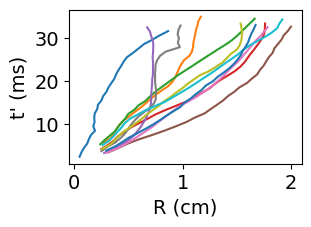

In [253]:
#plot alignment
fig,ax=plt.subplots(figsize=(3,2))
for index_pairs,row in df_P.iterrows():
    df=df_R[df_R['index_pairs']==index_pairs]
    d=df.sort_values(by='tdeath').head(30)
    x_values=d[R_col].values
    y_values=d['tdeath_align'].values
    #plot alignment
    plt.plot(x_values,y_values)
format_plot(ax=plt.gca(),xlabel='R (cm)', ylabel="t' (ms)",fontsize=14)
plt.show()

In [ ]:
# fig,ax=plt.subplots()
# for i,pid in enumerate(pid_lst_stumps):
#     dd=traj[traj[pid_col]==int(pid)]
#     dd.plot.scatter(x='x',y='y',ax=ax,color=f"C{i}")
# plt.show()

In [150]:
# #DONE: ROOT CAUSE ANALYSIS on why the lengths of 9/10 trajectories have only two data points
# #DONE: plot all spiral tip positions with fewer than 5 counts to their pair
# # # dfr.head()
# fig,ax=plt.subplots()
# for i,pid in enumerate(pid_lst_stumps):
#     dd=traj[traj[pid_col]==int(pid)]
#     dd.plot.scatter(x='x',y='y',ax=ax,color=f"C{i}")
# plt.show()
# #TODO(?): plot the annihilation partner with the shortest lifetime

In [ ]:
# fig, ax = plt.subplots(figsize=(4,4))
# #DONE: plot raw locations
# df_log.tail(200).plot.scatter(x='x',y='y',c='t',ax=ax)
# #DONE: plot trajectories
# # traj.tail(200).plot.scatter(x='x',y='y',c='t',ax=ax)
# format_plot(ax=ax,xlabel='x (pixels)',ylabel='y (pixels)')
# plt.show()

# TODO: boostrap xy values to compute MSR(t')

In [506]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [546]:
##########################
# GOAL: Compute MSR(t')
##########################
R_col='R_nosavgol'
# R_col='R'
T_col='tdeath_align'
# T_col='tdeath'

In [547]:
# dict_msr.keys()


In [548]:
SR_values_lst=[]
tau_values_lst=[]
count_events=0
for dict_msr in dict_msr_lst:
    #recall the data values
    df_R=dict_msr['df_R']
    SR_values=df_R[R_col].values**2
    tau_values=df_R[T_col].values
    #count the number of events
    num_events=df_R['index_pairs'].drop_duplicates().values.shape[0]

    #remove any null values
    boo_nan=np.isnan(tau_values)#tdeath_align has 6/1700 data points as null
    boo_nan|=np.isnan(SR_values)
    SR_values=SR_values[~boo_nan].copy()
    tau_values=tau_values[~boo_nan].copy()

    #record
    SR_values_lst.append(SR_values)
    tau_values_lst.append(tau_values)
    count_events+=num_events
SR_values=np.concatenate(SR_values_lst)
tau_values=np.concatenate(tau_values_lst)

    
    
num_trials=len(SR_values_lst)
num_obs=SR_values.shape[0]
print(f"aggregated N''={num_obs} R(t') observations from N'={num_trials} termination events. this involved N={count_events} pair-annihilation events.")
# num_trials,len(tau_values_lst),num_obs,tau_values.shape[0] #they're the same

aggregated N''=984939 R(t') observations from N'=577 termination events. this involved N=27696 pair-annihilation events.


In [549]:
#DONE: investigate which parameter setting needs to be changed to make df_smoothed mapping to dfr have dfr with {num_particles/2=}, {num_pairs=}
#DONE: wrap up to here into 1-3 functions for a dask.bag routine
#DONE: wrap routine as func foo
#DONE: eval_routine
#TODO: plot the MSR, as before
#heretimheretim

In [550]:
# if printing:
#     print(f"removed {sum(boo_nan)} data points due to having null x-value (or y-value)") #~6 per 1700 removed bc of alignment of time
assert not np.isnan(SR_values).any() and not np.isnan(tau_values).any()
SR_values.shape,tau_values.shape

((984939,), (984939,))

In [551]:
np.max(tau_values)

161.57694707168534

In [553]:
#compute bootstrap 
x_values_in=tau_values
y_values_in=SR_values
# bins='auto'
bins=np.arange(0,200,1)
df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,
                               y_values_in,
                               xlabel='tdeath_avg',
                               ylabel='MSR',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=1000,
                               npartitions=10,
                               use_test=False)
df_bootstrap.head()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
0,2.760628,0.092384,0.004244,0.001426,0.814711,0.057715,4039
1,3.649537,0.115794,0.004168,0.001482,0.798826,0.425815,9809
2,4.607775,0.151028,0.003371,0.001694,0.764488,0.349283,13848
3,5.509449,0.155773,0.003792,0.001590,0.167368,0.946909,16156
4,6.501053,0.197168,0.003966,0.002046,0.738143,0.454847,15579


In [554]:
x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

((147,), (147,), (147,))

Does this appear to intersect at zero?


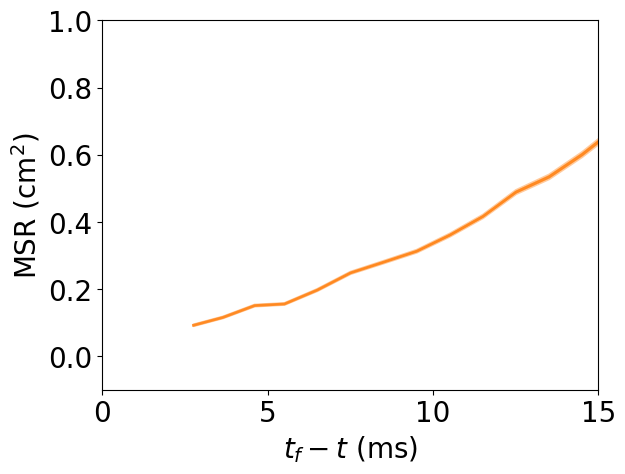

In [555]:
print(f"Does this appear to intersect at zero?")
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.xlim([0,15])
plt.ylim([-.1,1])
plt.show()

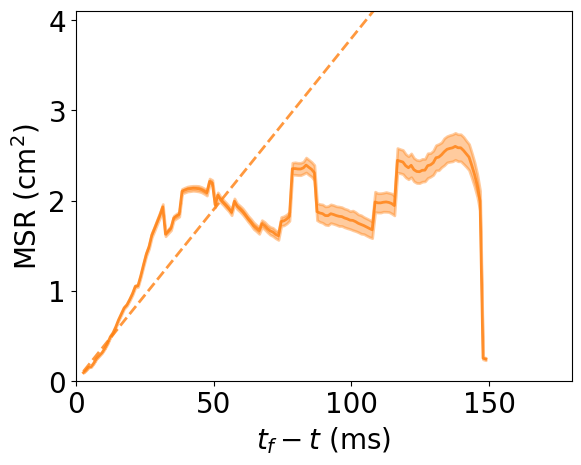

In [556]:
#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# plt.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,180])
plt.ylim([0,4.1])
plt.show()

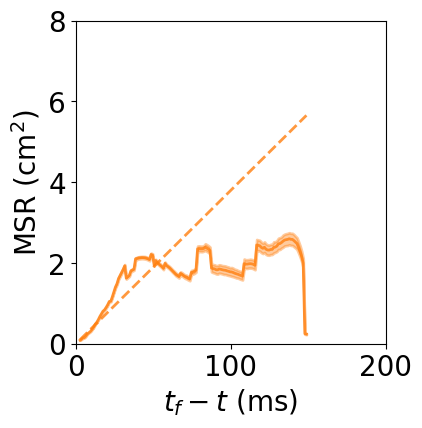

In [557]:
#plot expected
fig,ax=plt.subplots(figsize=(4,4.2))
ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,200])
ax.set_ylim([0,8])
plt.show()

# visualize the msr, compute its autocorrelation period, and save the analogas msr_lr_bootstraped file using wouter's data
- HINT: this was copied from src: #http://localhost:8890/notebooks/tests%20for%20screening%20via%20density%20dependence%20of%20attraction%20coefficients.ipynb


In [ ]:
from scipy import signal
from scipy.signal import argrelextrema

tmax=300
sig = y_values-4*1.6*1e-3*x_values
boo=x_values<tmax
DT=np.diff(x_values)[0]
sig=sig[boo].copy()
corr = signal.correlate(sig, sig)
lags = signal.correlation_lags(len(sig), len(sig))
corr /= np.max(corr)

# for local_maxima
local_maxima=argrelextrema(corr, np.greater)

# for local_minima
local_minima=argrelextrema(corr, np.less)

#TODO: find period of MSR before death
taumax_values=DT*lags[local_maxima]
taumin_values=DT*lags[local_minima]
np.diff(taumin_values),np.diff(taumax_values)

print(f"Periods of Autocorrelation of MSR (ms):")
print(np.diff(taumax_values))
yv=np.linspace(0,1,20)
for taumax in taumax_values:
    plt.plot(taumax+0.*yv,yv,'k--',alpha=0.5,lw=2)
    
plt.plot(DT*lags,corr,lw=2)
format_plot(ax=plt.gca(),xlabel=r'$\tau$ (ms)',ylabel=r'Autocorr. of MSR')
plt.show()

# # tmax=8#ms
# tmax=1e3#ms
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_SR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s")
print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

#DONE: record ^this in .odg
#DONT: does R values have units of cm when it is saved?  maybe I'm missing a scale of 5/200???^2???
#DONE: repeat with all samples!
#TODO: repeat with more/less smoothingi
1

#save as .csv
# modname='msr_fk'
# # modname='msr_lr'
save_folder=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results"
os.listdir(save_folder)
msr_csv_fn=f"{modname}_boostrapped_tavg2_{tavg2:.1f}_n_{max_num_groups}_a_{a_SR:.1f}_tmax_{tmax}.csv"
msr_csv_dir=os.path.join(save_folder,msr_csv_fn)
# df_bootstrap.to_csv(msr_csv_dir,index=False)
msr_csv_dir

beep(4)

#plot a versus t_f-t using (i) finite diff and (ii) using savgol
xmid_values=0.5*(x_values[1:]+x_values[:-1])
dydx_values=np.diff(y_values)/np.diff(x_values)
xmid_values=moving_average(xmid_values,4)
dydx_values=moving_average(dydx_values,4)
plt.plot(xmid_values,dydx_values/4*1e3,c=c)

#plot expected
plt.plot(x_values,9.5+0.*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,1.6+0.*x_values,'--',lw=2,alpha=0.8,c='C0')

format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'a (cm$^2$/s)')
plt.xlim([0,1000])
plt.show()

#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,4*1.6*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

beep(3)

#TODO: repeat for FK model

#TODO: save df_Ri
df_Ri.head()

# (ignore) the previous version to compute MSR (i think)

In [ ]:
##########################
# Compute MSR
##########################
R_col='R_nosavgol'

# R_col='R'

In [ ]:
minnumobs=8
#fenton karma msr dataframe
groups=dfr.groupby('tdeath')
tdeath_lst=[]
avg_lst=[]
stderror_lst=[]
sqavg_lst=[]
sqstderror_lst=[]
count_lst=[]
for n,g in groups:
    ##DONE: print each tdeath value 
    # print(n)
    gr=g[R_col]
    counts=gr.count()#.values
    if (minnumobs<=counts).all():
        #TODO: compute average and stderror of each group of tdeath
        avg=gr.mean()#.values
        stddev=gr.std()#.values
        stderror=stddev/np.sqrt(counts)
        
        #TODO: compute squared average
        sq=gr**2
        sqavg=sq.mean()#.values
        sqstddev=sq.std()#.values
        sqstderror=sqstddev/np.sqrt(counts)
        #record
        tdeath_lst.append(n)        
        avg_lst.append(avg)
        stderror_lst.append(stderror)
        sqavg_lst.append(sqavg)
        sqstderror_lst.append(sqstderror)
        count_lst.append(counts)
        
#collect each field into a pandas.DataFrame
df_msr=pd.DataFrame({
    'tdeath':tdeath_lst,
    'avg':avg_lst,
    'stderror':stderror_lst,  
    'sqavg':sqavg_lst,
    'sqstderror':sqstderror_lst,  
    'counts':count_lst
})    

In [ ]:
df_msr.sort_values(by='tdeath',inplace=True)
x_values=df_msr['tdeath'].values
y_values=df_msr['sqavg'].values**.5
yerr_values=df_msr['sqstderror'].values

In [ ]:
xmin=0#.1
xmax=150
# c='C1'
c='k'
#plot ^those resulting df_msr versus tdeath
plt.plot(x_values,y_values,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,color=c,alpha=0.5)
# plt.plot(x_values_lr,y_values_lr,c='C1')
# plt.fill_between(x_values_lr,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,color='C1',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)',use_loglog=False)
plt.xlim([xmin,xmax])
xv=np.linspace(xmin,xmax,100)
# plt.plot(xv,xv*4*1.6*1e-3,'C0--',lw=2,alpha=0.7)
plt.plot(xv,xv*4*(9.4+2*0.58)*1e-3,'C1--',lw=2,alpha=0.7)
# plt.xlim([0,1])
plt.ylim([0,2])
# plt.ylim([0.5,2])
fontsize=16
# plt.legend(fontsize=fontsize-4,loc='upper right')
plt.title('_Results from Evaluation of the Full Model_\nDotted Lines indicate the Linear Particle Model with Diffusion\n',fontsize=fontsize)
plt.show()
print(f'R_col={R_col}, tavg1={tavg1} ms, tavg2={tavg2} ms')

In [ ]:
# HINT: was ^that in bgmc?

In [ ]:
# #GOAL: compute the msr_values simply without any kind of smoothing, and plot with the computed msr_values
# # option 1: turn off smoothing in generation of df
# bins=np.arange(0,2000)
# tau_values=0.5*(bins[:-1]+bins[1:])
# #TODO: bin and bootstrap dfr, as before
#TODO: plot the two methods of computing msr_values. compare. share with WJ.

In [ ]:
# #TODO: compute msr_values from df_annihilations, as before, with smoothing


In [ ]:
#DONT: plot the same example R_values with and without smoothing
#NOTE: it looks like i didn't use any smoothing

In [ ]:
# DONE(bonus): FlowerPlot the trajectories before/after smoothing
#HINT: unwrap traj, as before
# #HINT for unwrapping trajectories
# pid_lst = sorted(set(df[pid_col].values))
# #(duplicates filtered earlier_ _  _ _ ) filter_duplicate_trajectory_indices is slow (and can probs be accelerated with a sexy pandas one liner)
# pid_lst_filtered = pid_lst#filter_duplicate_trajectory_indices(pid_lst,df)
# # pid_lst_filtered = filter_duplicate_trajectory_indices(pid_lst,df)
# df = pd.concat([unwrap_traj_and_center(df[df[pid_col]==pid], width, height, DS, **kwargs) for pid in pid_lst_filtered])

In [ ]:
#DONE: view trajectories
# fig, ax = plt.subplots(figsize=(4,4))
# #DONE: plot raw locations
# #DONE: plot trajectories
# #DONE: plot smoothed trajectories
# # df_log.tail(200).plot.scatter(x='x',y='y',c='t',ax=ax)
# df.tail(200).plot.scatter(x='x',y='y',c='t',ax=ax)
# # traj.tail(200).plot.scatter(x='x',y='y',c='t',ax=ax)
# format_plot(ax=ax,xlabel='x (pixels)',ylabel='y (pixels)')
# plt.show()

#DONE: find annihilation pairs, as before
#DONE: compute df_annihilations, as before
# #TODO(later): save as .csv
##HINT:
# log_dir=os.path.abspath(input_fn)+'_log.csv'
# df_loc.to_csv(log_dir,index=False)

In [ ]:
#TODO: record
#TODO: format output
# #(optional) drop all feature columns that are not relevant here
# col_drop_lst=set(df.columns).difference(col_keep_lst)
# df.drop(columns=col_drop_lst,inplace=True)
# if printing:
#     print(f"features dropped: {col_drop_lst}")
#     print(f"note: ^these can be recovered using the index")

#TODO: save msr_values, as before
#TODO: save dfr and df_pairs

# scratchwerk

In [ ]:
#DONT: # option 2: implement it fresh
# #TODO: compute the R_values,tau_values simply without any kind of smoothing, and plot with the computed msr_values
# # #TODO: compute smoothed msr, as before
# R_lst=[]
# tau_lst=[]
# for d in df_annihilations.iterrows():
#     pass
# #for each row of df_annihilations, compute subtract_pbc  
# #HINT: subtract the values
# # #HINT for subtracting two points
# # subtract_pbc=get_subtract_pbc(width=width,height=height)
# # w=subtract_pbc(point,segment[0])


In [ ]:

# #infer filesystem for saving functionally from inputs
# trgt='_tavg'
# tavg1=float(eval(input_fn[input_fn.find(trgt)+len(trgt):].split('/')[0].split('_')[-1]))
# ext = f'_annihilations_denoised.csv'
# folder_ext=f'_tavg1_{tavg1}_tavg2_{tavg2}_maxdtmax_{max_dtmax_thresh}_maxRfin_{max_Rfinal_thresh}_mindur_{min_duration_thresh}'
# save_fn = os.path.basename(input_fn).replace('.csv', ext)

# if save_df_pairs:
#     #save df_pairs data from input_fn in dfr
#     save_folder = os.path.dirname(
#         os.path.dirname(input_fn)
#     ) + f'/pairs'+folder_ext
#     if not os.path.exists(save_folder):
#         os.mkdir(save_folder)
#     os.chdir(save_folder)
#     df_pairs.reset_index().to_csv(save_fn,index=False)
#     # pairs_dir = os.path.join(save_folder, save_fn)
#     pairs_dir = os.path.abspath(save_fn)

# #save dfr data from input_fn in dfr
# save_folder = os.path.dirname(
#     os.path.dirname(input_fn)
# ) + f'/smoothed_annihilations'+folder_ext
# if not os.path.exists(save_folder):
#     os.mkdir(save_folder)
# os.chdir(save_folder)
# dfr.reset_index().to_csv(save_fn,index=False)
# # dfr_dir = os.path.join(save_folder, save_fn)
# dfr_dir = os.path.abspath(save_fn)

In [ ]:
#DONE: see if the gpu-accelerated version works, as before
#DONT(later): make a cpu version of the unwrapping pipeline 
#HINT: i have unwrapping working on cpu, not sure about moving_avg_pbc
# #DONT: use the gpu version for all these mini-termination events
# # from lib.rapids_func.utils.unwrap_and_smooth_cu import apply_unwrap_xy_trajectories_pbc, apply_moving_avg_xy_trajectories
# #DONT: move to lib in lib.utils.unwrap_and_smooth.py
# def apply_unwrap_xy_trajectories_pbc_serial(df,t_col,pid_col,width,height,**kwargs):
#     #now we only have good data...  we can compute moving averages for each particle!
#     #allocate memory
#     df['dx_unwrap']=0.*df['x']
#     df['dy_unwrap']=0.*df['y']
#     df['x_unwrap']=df['x']
#     df['y_unwrap']=df['y']
#     #TODO(optional): reset the index... not needed and ruins reconstruction of dropped columns at the end...  don't do it...
#     # df.reset_index(inplace=True)
#     #apply unwrapping to x and y
#     df['incol']=df['x']
#     grouped = df.groupby(pid_col)
#     uwargs={'jump_thresh':width/2,"width":width}
#     df = grouped.apply(unwrapper_pbc,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), kwargs=
#                                uwargs)
#     df['dx_unwrap']=df['outcol']

#     df['incol']=df['y']
#     grouped = df.groupby(pid_col)
#     uwargs={'jump_thresh':height/2,"width":height}
#     df = grouped.apply(unwrapper_pbc,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), kwargs=
#                                uwargs)
#     df['dy_unwrap']=df['outcol']

#     df.drop(columns=['incol','outcol'],inplace=True)

#     #DONE: confirmed ^that was nontrivial and reasonable looking
#     # (df['dx_unwrap']!=0).any(),(df['dy_unwrap']!=0).any()
#     # df[df['dx_unwrap']!=0].head()
#     # (True,True)

#     #aggregte over jumps
#     grouped_unwrap=df.groupby(pid_col)

#     #aggregate along a given columns in grouped_unwrap
#     result=grouped_unwrap[['dx_unwrap','dy_unwrap']].cumsum()

#     #map result back onto df using reindexing ninjitsu
#     cp_col_lst=['dx_unwrap','dy_unwrap']
#     df.reset_index(inplace=True)
#     result.reset_index(inplace=True)
#     for col in cp_col_lst:
#         df[col]=result[col]
#     df.set_index('index',inplace=True)

#     #compute unwrapped coordinates
#     df['x_unwrap']=df['x']+df['dx_unwrap']
#     df['y_unwrap']=df['y']+df['dy_unwrap']
#     return df

# def apply_moving_avg_xy_trajectories_serial(df,t_col,pid_col,navg1,x_col='x_unwrap',y_col='y_unwrap',**kwargs):
#     diffx_col='diff'+x_col
#     diffy_col='diff'+y_col
#     #apply smoothing to x and y after unwrapping
#     df['incol']=df[x_col]
#     grouped = df.groupby(pid_col)
#     if navg1>0:
#         mawargs={'win_size':navg1}
#         df = grouped.apply(rolling_avg,
#                                        incols=['incol'],
#                                        outcols=dict(outcol=np.float64), kwargs=
#                                    mawargs)
#         df[x_col]=df['outcol']

#         df['incol']=df[y_col]
#         grouped = df.groupby(pid_col)
#         df = grouped.apply(rolling_avg,
#                                        incols=['incol'],
#                                        outcols=dict(outcol=np.float64), kwargs=
#                                    mawargs)
#         df[y_col]=df['outcol']
#     # else:
#     #     #perform no moving average if the window is of size zero
#     #     pass
#     # #drop data that isn't needed anymore
#     #DONE: verified that dropping data here doesn't affect the number of final nonnan values
#     # df.drop(columns=['incol','outcol'],inplace=True)
#     df.dropna(inplace=True)
#     # df.head()

#     #apply smoothing to x and y after unwrapping
#     df['incol']=df[x_col]
#     grouped = df.groupby(pid_col)
#     mdwargs={'win_size':2}
#     df = grouped.apply(rolling_diff,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), kwargs=
#                                mdwargs)
#     df[diffx_col]=df['outcol']

#     df['incol']=df[y_col]
#     grouped = df.groupby(pid_col)
#     df = grouped.apply(rolling_diff,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), kwargs=
#                                mdwargs)
#     df[diffy_col]=df['outcol']

#     #drop data that isn't needed anymore
#     df.drop(columns=['incol','outcol'],inplace=True)
#     # df.dropna(inplace=True)

#     #compute the naive speed of the unwrapped trajectories in pixels per frame
#     df['speed']=cp.sqrt(df[diffx_col]**2+df[diffy_col]**2)#pixels per frame
#     # df['speed']=cp.sqrt(df['diffx_unwrap']**2+df['diffy_unwrap']**2)#pixels per frame#*DS/DT*10**3 #cm/s

#     # #DONE: test and verify that the largest stepsize in the unwrapped xy is reasonable for both x and y
#     # max_speed_values=df.groupby(pid_col)['speed'].max().values
#     # plt.hist(max_speed_values.get(),bins=30)
#     # plt.xlabel('max pixel displacement between two frames')
#     # max_speed_warning=20 #pixels per frame
#     # assert ((max_speed_values.get()<max_speed_warning).all())
#     # plt.show()
#     return df

# d = {"my_label": Series(['A','B','A','C','D','D','E'])}
# df = DataFrame(d)


# def as_perc(value, total):
#     return value/float(total)

# def get_count(values):
#     return len(values)

# # grouped_count = df.groupby("my_label").my_label.agg(get_count)
# grouped = df.groupby(pid_col)
# data = grouped.apply(unwrapper_pbc_serial, total=df.my_label.count())

# def unwrapper_pbc_serial(incol, jump_thresh, width):
#     '''
#     Example Usage: for cudf.DataFrame instance
#     df['incol']=df['x']
#     grouped = df.groupby(pid_col)
#     df = grouped.apply_grouped(unwrapper_pbc,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), jump_thresh=width/2)
#     df['dx_unwrap']=df['outcol']
#     df.head()
#     '''

# def unwrapper_pbc(incol, outcol, jump_thresh, width):
#     '''
#     Example Usage: for cudf.DataFrame instance
#     df['incol']=df['x']
#     grouped = df.groupby(pid_col)
#     df = grouped.apply_grouped(unwrapper_pbc,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), jump_thresh=width/2)
#     df['dx_unwrap']=df['outcol']
#     df.head()
#     '''
#     e=incol
#     de_unwrap=outcol
#     #for i in range(cuda.threadIdx.x, len(e), cuda.blockDim.x):
#     for i in range(cuda.threadIdx.x, len(e), cuda.blockDim.x):
#         de_unwrap[i]=0
#         if i>0:
#             de=e[i]-e[i-1]
#             jump_plus=de<-jump_thresh
#             jump_minus=de>jump_thresh
#             if jump_plus:
#                 de_unwrap[i]=width
#             elif jump_minus:
#                 de_unwrap[i]=-width